# Testing time cunsumption for different GLM alogrithms  
## 1. Import data
### 1.1. Set parameters

In [11]:
import pandas as pd
import numpy as np
import patsy
import mne
import os
import glob
import re
import matplotlib.pyplot as plt

event = 'Auditory'
stat = 'power'  # or 'zscore'
fif_name = f'{event}_{stat}-epo.fif'
task_Tag = 'Yes_No'

HOME = os.path.expanduser("~")
LAB_root = os.path.join(HOME, "Box", "CoganLab")
clean_root = os.path.join(LAB_root, 'BIDS-1.0_LexicalDecRepDelay', 'BIDS', "derivatives", "clean")
stats_root = os.path.join(LAB_root, 'BIDS-1.0_LexicalDecRepDelay', 'BIDS', "derivatives", "stats")

subjs = [name for name in os.listdir(stats_root) if
         os.path.isdir(os.path.join(stats_root, name)) and name.startswith('D')]
import warnings

subjs = [subj for subj in subjs if
         subj != 'D0107' and subj != 'D0042']  # and subj != 'D0028']
if task_Tag == 'Yes_No':
    subjs = [subj for subj in subjs if subj != 'D0115']
warnings.warn(f"The following subjects are not included: D0107 D0042")

subjs=['D0096']

C:\Users\bl314\AppData\Local\Temp\ipykernel_3276\3562413087.py:28: UserWarning: The following subjects are not included: D0107 D0042
  warnings.warn(f"The following subjects are not included: D0107 D0042")


### 1.2. Loop to import data

In [12]:
# %% start looping to load patients
data_list = []
filtered_events_list = []
chs = []

for i, subject in enumerate(subjs):
    print(f"Now do patent {subject}")

    #%% Load fif data
    subject_label_chs = 'D' + subject[1:].lstrip('0')
    subject = "sub-"+subject
    subject_No = subject.replace("sub-", "")
    subj_gamma_stats_dir = os.path.join(stats_root, subject_No)
    file_dir = os.path.join(subj_gamma_stats_dir, fif_name)
    epochs=mne.read_epochs(file_dir, False, preload=True)

    #%% Load events
    subj_gamma_clean_dir = os.path.join(clean_root, subject,'ieeg')
    files = glob.glob(os.path.join(subj_gamma_clean_dir, '*acq-*_run-*_desc-clean_events.tsv'))
    files_sorted = sorted(files, key=lambda x: [int(i) for i in re.findall(r'acq-(\d+)_run-(\d+)', x)[0]])
    dfs = [pd.read_csv(f, sep='\t') for f in files_sorted]
    events_df = pd.concat(dfs, ignore_index=True)
    filtered_events_i = events_df[events_df['trial_type'].str.contains(event)
                                & events_df['trial_type'].str.contains('CORRECT')
                                & events_df['trial_type'].str.contains(task_Tag)].reset_index(drop=True)
    trial_split = filtered_events_i['trial_type'].str.split('/', expand=True)
    trial_split.columns = ['Stage', 'RepYesNo', 'Wordness', 'Stim', 'Correctness']
    filtered_events_i = pd.concat([filtered_events_i, trial_split], axis=1)
    for col in ['Stage', 'RepYesNo', 'Wordness', 'Stim', 'Correctness']:
        filtered_events_i[col] = filtered_events_i[col].astype('category')

    if subject == 'sub-D0102' and task_Tag=='Repeat':
        filtered_events_i = filtered_events_i[:-1]
        
    # Get data
    if event=='Auditory':
        data_i = epochs[f'Auditory_stim/{task_Tag}/CORRECT'].get_data()
    elif event=='Resp':
        data_i = epochs[f'Resp/{task_Tag}/CORRECT'].get_data()
    if i == 0:
        times = epochs.times
    chs_i = epochs.ch_names
    chs_i = [f"{subject_label_chs}-{ch}" for ch in chs_i]

    # Feature matrix
    wordness_dummy = (filtered_events_i.Wordness == "Word").astype(float)
    X_i = np.column_stack([np.ones(np.shape(data_i)[0]), wordness_dummy])
    feature_mat_i = np.repeat(X_i[:, np.newaxis, :], np.shape(data_i)[1], axis=1)
    
    # store data
    data_list.append(data_i)
    filtered_events_list.append(feature_mat_i)
    chs.append(chs_i)


Now do patent D0096
Reading C:\Users\bl314\Box\CoganLab\BIDS-1.0_LexicalDecRepDelay\BIDS\derivatives\stats\D0096\Auditory_power-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    2990.00 ms
        0 CTF compensation matrices available
Not setting metadata
274 matching events found
No baseline correction applied


### 1.3. Generate a big data matrix (not used now, since permutation is done within single subjects)

In [29]:
# # Calculate maximum number of trials and total channels
# max_trials = max(d.shape[0] for d in data_list)
# total_channels = sum(d.shape[1] for d in data_list)
# n_times = data_list[0].shape[2]  # Assume n_times is the same for all subjects
# 
# data = np.full((max_trials, total_channels, n_times), np.nan)
# feature_mat = np.full((max_trials, total_channels, 2), np.nan)
# channel_offset = 0
# for i, data_i in enumerate(data_list):
#     n_trials_i, n_channels_i, _ = data_i.shape
#     data[:n_trials_i, channel_offset:channel_offset + n_channels_i, :] = data_i
#     feature_mat_i = filtered_events_list[i]
#     feature_mat[:n_trials_i, channel_offset:channel_offset + n_channels_i, :] = feature_mat_i
#     channel_offset += n_channels_i
# 
# print("Data shape:", data.shape)
# print("Feature matrix shape:", feature_mat.shape)
# print("Total channels:", len(chs))

Data shape: (130, 171, 350)
Feature matrix shape: (130, 171, 2)
Total channels: 171


## 2. Compare model speed 
### 2.1. statsmodels OLS

In [27]:
import statsmodels.api as sm
#from mne.stats import fdr_correction
def sm_glm(x,y):
    # x: observations (only one feature now)
    # y: observations
    # will get beta for one time point of the y: Y(t)=betas(t)X(t)+e
    # return: beta
    df = pd.DataFrame({'Y': y, 'X': x})
    formula = 'Y ~ X'
    Y, X = patsy.dmatrices(formula, data=df, return_type='dataframe')
    model = sm.OLS(Y, X, missing='drop')
    results = model.fit()
    beta = results.params.iloc[1]
    return beta

In [28]:
betas=[]
for i, data_i in enumerate(data_list):
    _, n_channels_i, n_times = data_i.shape
    feature_mat_i = filtered_events_list[i]
    beta_i = np.full((n_channels_i, n_times), np.nan)
    for ch in range(n_channels_i):
        print(f"patient {subjs[i]} chs {ch}")
        for ti in range(n_times):
            x = feature_mat_i[:, ch, 1]
            y = data_i[:, ch, ti]
            beta_i[ch,ti] = sm_glm(x,y)
    betas.append(beta_i)
betas_smols=np.concatenate(betas, axis=0)

patient D0096 chs 0
patient D0096 chs 1
patient D0096 chs 2
patient D0096 chs 3
patient D0096 chs 4
patient D0096 chs 5
patient D0096 chs 6
patient D0096 chs 7
patient D0096 chs 8
patient D0096 chs 9
patient D0096 chs 10
patient D0096 chs 11
patient D0096 chs 12
patient D0096 chs 13
patient D0096 chs 14
patient D0096 chs 15
patient D0096 chs 16
patient D0096 chs 17
patient D0096 chs 18
patient D0096 chs 19
patient D0096 chs 20
patient D0096 chs 21
patient D0096 chs 22
patient D0096 chs 23
patient D0096 chs 24
patient D0096 chs 25
patient D0096 chs 26
patient D0096 chs 27
patient D0096 chs 28
patient D0096 chs 29
patient D0096 chs 30
patient D0096 chs 31
patient D0096 chs 32
patient D0096 chs 33
patient D0096 chs 34
patient D0096 chs 35
patient D0096 chs 36
patient D0096 chs 37
patient D0096 chs 38
patient D0096 chs 39
patient D0096 chs 40
patient D0096 chs 41
patient D0096 chs 42
patient D0096 chs 43
patient D0096 chs 44
patient D0096 chs 45
patient D0096 chs 46
patient D0096 chs 47
pa

### 2.2. Numpy's lstsq

In [90]:
def compute_beta_ch(x, y):
    # x: observations * features
    # y: observations * times
    # will get beta for each time point of the y: Y(t)=betas(t)X(t)+e
    # return: beta: features * times
    mask = ~np.isnan(y[:,0])
    y_clean = y[mask,:]
    x_clean = x[mask,:]
    beta = np.linalg.lstsq(x_clean, y_clean, rcond=None)[0]
    return beta[:,:]

def compute_beta_loop(feature_mat_i,data_i):
    # feature_mat_i: feature matrix, observations * channels * features
    # data_i: eeg data matrix, observations * channels * times
    # return beta_i: beta matrix, channels * (features -1) * times (remove the intercept)
    _, n_channels_i, n_times = data_i.shape
    _, _, n_features = feature_mat_i.shape
    beta_i = np.full((n_channels_i, n_features, n_times), np.nan)
    for ch in range(n_channels_i):
        x = feature_mat_i[:, ch, :]
        y = data_i[:, ch, :]
        beta_i[ch,:,:] = compute_beta_ch(x,y)
    return beta_i

In [107]:
betas=[]
for i, data_i in enumerate(data_list):
    feature_mat_i = filtered_events_list[i]
    compute_beta_loop_i = lambda data: compute_beta_loop(feature_mat_i, data)
    beta_i = compute_beta_loop_i(data_i)
    beta_i = beta_i[:, 1, :]
    # beta_i = np.reshape(beta_i,[beta_i.shape[0],beta_i.shape[2]])
    betas.append(beta_i)  

betas_lstsq=np.concatenate(betas, axis=0)

pz


#### 2.2.1. Try permutation

In [106]:
from scipy.stats import permutation_test
ress=[]
for i, data_i in enumerate(data_list):
    feature_mat_i = filtered_events_list[i]
    res=permutation_test([feature_mat_i,data_i], compute_beta_loop, permutation_type='pairings',n_resamples=100,alternative='two-sided', axis=0)
    ress.append(res)  

ValueError: Array shapes are incompatible for broadcasting.

## 3. Compare results (statsmodels OLS is set as standard)

In [25]:
   # Plot GLM
def plot_beta(data_in,title):
    
    plt.figure(figsize=(10, 5))
    plt.imshow(data_in, aspect='auto', cmap='gray_r', interpolation='nearest')
    plt.colorbar(label="Beta values")
    plt.xlabel("Time points")
    plt.ylabel("Channels")
    plt.title(title)
    
    xticks = np.arange(0, len(times), 20)
    plt.xticks(ticks=xticks, labels=np.round(times[xticks], 2))
    plt.xlabel("Time (s)")
    # 
    # yticks = np.arange(0, len(chs), 5)
    # plt.yticks(ticks=yticks, labels=[chs[i] for i in yticks])
    plt.ylabel("Channels")
    
    zero_time_index = np.argmin(np.abs(times - 0))
    plt.axvline(x=zero_time_index, color='red', linestyle='--', linewidth=1.5, label="Time = 0")
    
    plt.show()

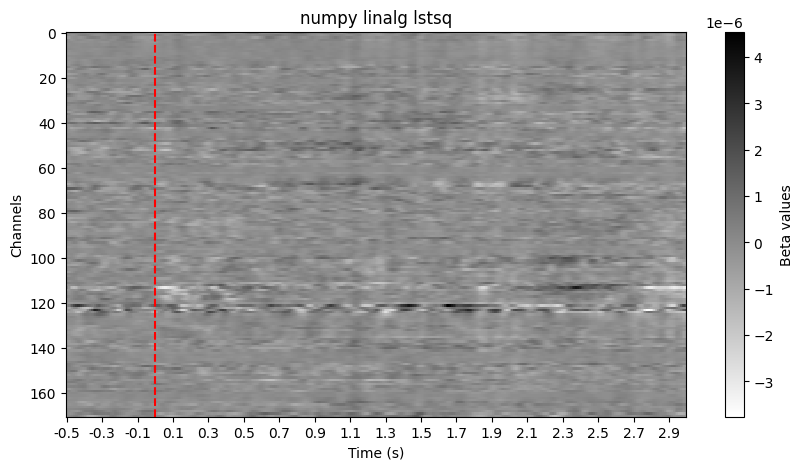

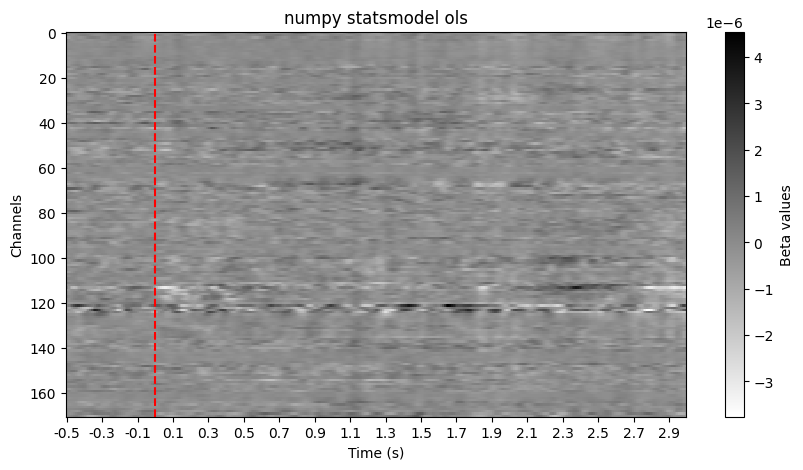

In [88]:
plot_beta(betas_lstsq,'numpy linalg lstsq')
plot_beta(betas_smols,'numpy statsmodel ols')